# Spiker 

Classic Hodgkin-Huxely-based Spiker model.

In [1]:
# Set the path
import sys
sys.path.append("../../")

from act.cell_model import ACTCellModel
from act.simulator import ACTSimulator
from act.types import SimulationParameters, ConstantCurrentInjection, FilterParameters, ConductanceOptions, OptimizationParameters
import act.data_processing as dp
from act.module import ACTModule

import numpy as np
import matplotlib.pyplot as plt

from act.passive import ACTPassiveModule
from act.segregation import ACTSegregator

from sklearn.metrics import mean_absolute_error
from act.metrics import pp_error

--No graphics will be displayed.


## 1. Set the "target" model and simulate from it

The "target" model's output represents the target bio data provided by the user to tune for.

Parameters:
- Cm = 1
- gnabar = .12 (S/cm2)
- gkbar = .036 (S/cm2)
- gl = .0003 (S/cm2)
- el = -54.3 (mV)

In [2]:
# Define the "target" cell
target_cell = ACTCellModel(
    cell_name = "Spiker",
    path_to_hoc_file = "../../data/Spiker/orig/target_template.hoc",
    path_to_mod_files = "../../data/Spiker/orig/modfiles/",
    passive = ["gl", "el", None],
    active_channels = ["hh_spiker.gnabar", "hh_spiker.gkbar"],
)

In [3]:
target_g = np.array([0.0003, 0.12, 0.036])

### 1.1. Target passive properties

In [4]:
# Set simulations
simulator = ACTSimulator(output_folder_name = "output")

sim_params = SimulationParameters(
    sim_name = "target",
    sim_idx = 0,
    h_celsius = 6.3,
    h_dt = 0.1,
    h_tstop = 1000,
    CI = [ConstantCurrentInjection(amp = -0.2, dur = 700, delay = 100)])

simulator.submit_job(target_cell, sim_params)
simulator.run_jobs(1)


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


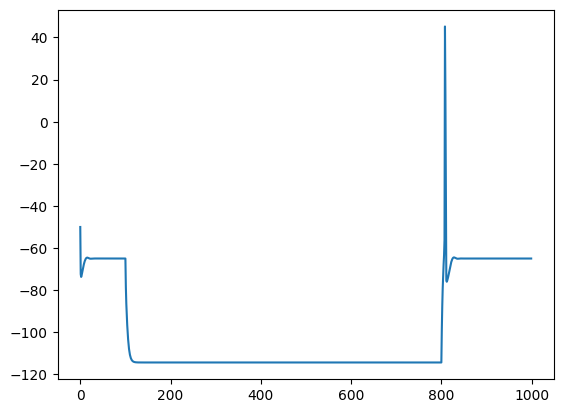

In [5]:
passive_trace = np.load("output/target/out_0.npy")[:, 0]
plt.plot(passive_trace[::10])

In [6]:
target_gpp = ACTPassiveModule.compute_gpp(passive_trace, 0.1, 100, 700, -0.2)
target_gpp

GettablePassiveProperties(R_in=np.float64(246.82388046911376), tau1=4.1000000000000005, tau2=544.9, sag_ratio=np.float64(0.0), V_rest=np.float64(-64.97367898269046))

### 1.2. Target FI curve

In [7]:
# Set simulations
simulator = ACTSimulator(output_folder_name = "output")

for sim_idx, amp_value in enumerate([0.1, 0.3, 0.5]):
    sim_params = SimulationParameters(
        sim_name = "target",
        sim_idx = sim_idx,
        h_celsius = 6.3,
        h_dt = 0.1,
        h_tstop = 1000,
        CI = [ConstantCurrentInjection(amp = amp_value, dur = 700, delay = 100)])

    simulator.submit_job(target_cell, sim_params)

simulator.run_jobs(3)

# Combine simulated traces into one dataset for convenience
dp.combine_data("output/target")


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        
output/target/combined_out.npy


Text(0, 0.5, 'Voltage (mV)')

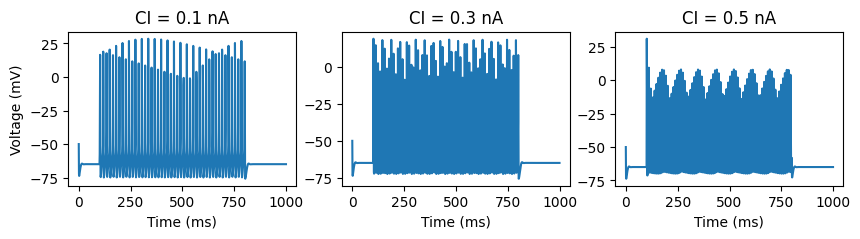

In [8]:
# Plot the traces and the FI curve
simulated_data = np.load("output/target/combined_out.npy") # 3 x 10000 x 4; (n_sim x time x [V, I, g, lto_hto])

fig, ax = plt.subplots(1, 3, figsize = (10, 2))
for axid, amp in enumerate([0.1, 0.3, 0.5]):
    ax[axid].plot(simulated_data[axid, ::10, 0])
    ax[axid].set_xlabel("Time (ms)")
    ax[axid].set_title(f"CI = {amp} nA")

ax[0].set_ylabel("Voltage (mV)")

Text(0.5, 1.0, 'FI Curve')

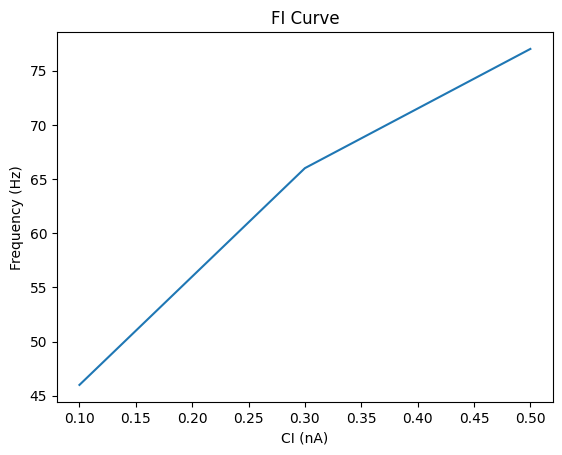

In [9]:
simulated_data = np.load("output/target/combined_out.npy")

f = []
for trace_id in range(len(simulated_data)):
    f.append(len(dp.find_events(simulated_data[trace_id, ::10, 0].flatten())))

plt.plot([0.1, 0.3, 0.5], f)
plt.xlabel("CI (nA)")
plt.ylabel("Frequency (Hz)")
plt.title("FI Curve")

## 3. Segregated pipeline

### 3.1. Segregate channels into functional modules

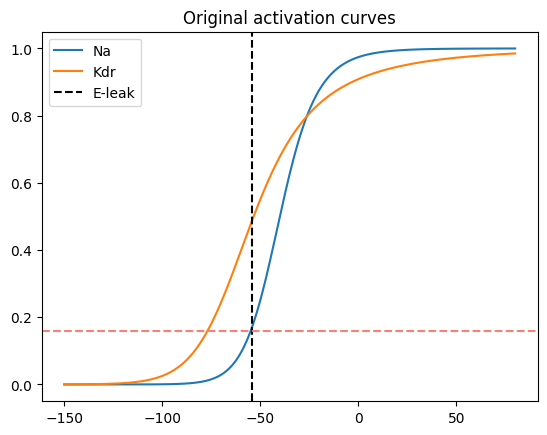

In [10]:
# From ACT/data/Spiker/orig/modfiles/hh.mod
def vtrap(x,y):
    if np.any(np.abs(x/y) < 1e-6):
        vtrap = y * (1 - x/y/2)
    else:
        vtrap = x / (np.exp(x/y) - 1)
    return vtrap

def Na(v):
    aNa = 0.1 * vtrap(-(v + 40), 10)
    bNa =  4 * np.exp(-(v + 65) / 18)
    return aNa / (aNa + bNa)

def Kdr(v):
    aK = 0.01 * vtrap(-(v + 55),10)
    bK = 0.125 * np.exp(-(v + 65) / 80)
    return aK / (aK + bK)

v = np.linspace(-150, 80, 1000)

plt.plot(v, Na(v), label = 'Na')
plt.plot(v, Kdr(v), label = 'Kdr')
plt.title("Original activation curves")
plt.axvline(-54.3, color = 'black', ls = '--', label = "E-leak")
plt.axhline(0.16, color = 'salmon', ls = '--')
plt.legend()

In [11]:
segregator = ACTSegregator()
seg_Na, seg_Kdr = segregator.segregate(v = v, activation_curves = [Na(v), Kdr(v)], v_rest = -65, dv_from_rest = 55)

Update the modfiles with the following:
----------
Activation curve 0:

        :Segregation
        if (v < -8) {
        replace_with_var_name = 0.476 * v + 4.756
        }
        if (v < -10) {
        replace_with_var_name = 0
        }
        
----------
Activation curve 1:

        :Segregation
        if (v < -8) {
        replace_with_var_name = 0.442 * v + 4.425
        }
        if (v < -10) {
        replace_with_var_name = 0
        }
        


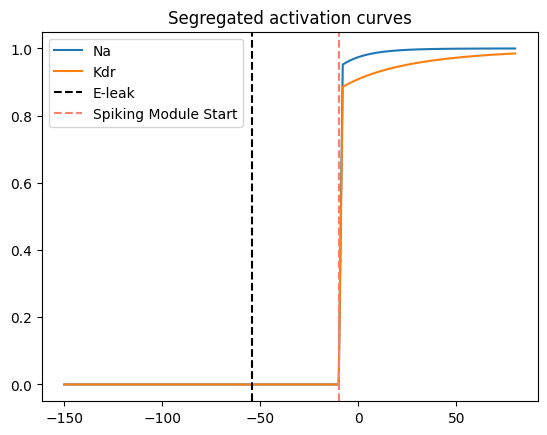

In [12]:
plt.plot(v, seg_Na, label = 'Na')
plt.plot(v, seg_Kdr, label = 'Kdr')
plt.title("Segregated activation curves")
plt.axvline(-54.3, color = 'black', ls = '--', label = "E-leak")
plt.axvline(-10, color = 'salmon', ls = '--', label = "Spiking Module Start")

plt.legend()

### 3.2. Run the passive module

In [13]:
train_cell = ACTCellModel(
    cell_name = "Spiker",
    path_to_hoc_file = "../../data/Spiker/seg/template.hoc",
    path_to_mod_files = "../../data/Spiker/seg/modfiles-10/",
    passive = ["gl", "el", None],
    active_channels = ["hh_spiker.gnabar", "hh_spiker.gkbar"],
)

In [14]:
simulator = ACTSimulator(output_folder_name = "output")

sim_params = SimulationParameters(
    sim_name = "spiker_dummy",
    sim_idx = 0,
    h_tstop = 10,
    CI = [],
    verbose = True
    )

simulator.run(train_cell, sim_params)


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        
Soma area: 1110.3645074847766
Soma diam: 18.8
Soma L: 18.8


In [15]:
user_provided_Rin = 246.82388046911376 * 1e6 # (Ohm) 
computed_soma_area = 1110.3645074847766 * 1e-8 # pi * diam * L + pi * diam^2 / 2 ; (cm2)
user_provided_tau = 4.1000000000000005 * 1e-3 # (sec)
user_provided_Vrest = -64.97367898269046 # (mV)

ACTPassiveModule.compute_spp(user_provided_Rin, computed_soma_area, user_provided_tau, user_provided_Vrest)

SettablePassiveProperties(Cm=1.4959983332281186, g_bar_leak=0.0003648776422507606, e_rev_leak=-64.97367898269046, g_bar_h=None)

**NOTE:** adjust these in the hoc file manually.

In [16]:
# Set simulations
simulator = ACTSimulator(output_folder_name = "output")

passive_cell = ACTCellModel(
    cell_name = "Spiker",
    path_to_hoc_file = "../../data/Spiker/seg/template.hoc",
    path_to_mod_files = "../../data/Spiker/seg/modfiles-10/",
    passive = ["gl", "el", None],
    active_channels = ["hh_spiker.gnabar", "hh_spiker.gkbar"],
)

sim_params = SimulationParameters(
    sim_name = "seg-10",
    sim_idx = 0,
    h_celsius = 6.3,
    h_dt = 0.1,
    h_tstop = 1000,
    CI = [ConstantCurrentInjection(amp = -0.2, dur = 700, delay = 100)])

simulator.submit_job(passive_cell, sim_params)
simulator.run_jobs(1)

passive_trace = np.load("output/seg-10/out_0.npy")[:, 0]
seg_gpp = ACTPassiveModule.compute_gpp(passive_trace, 0.1, 100, 700, -0.2)
seg_gpp


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


GettablePassiveProperties(R_in=np.float64(246.7411385144338), tau1=4.3, tau2=564.3000000000001, sag_ratio=np.float64(0.0), V_rest=np.float64(-64.9999999994438))

In [17]:
pp_error(target_gpp, seg_gpp)

[('R_in', np.float64(0.08274195467996037)),
 ('tau1', np.float64(0.1999999999999993)),
 ('tau2', np.float64(19.40000000000009)),
 ('sag_ratio', np.float64(0.0)),
 ('V_rest', np.float64(0.026321016753342974))]

### 3.3. Optimize active channels

In [18]:
# Parameter ranges as if provided by the user
gbar_leak = 0.00025
gbar_na = 0.132
gbar_kdr = 0.037

random_state = np.random.RandomState(123)
gbar_na_range = (gbar_na - random_state.uniform(0, gbar_na / 2), gbar_na + random_state.uniform(0, gbar_na / 2))
gbar_kdr_range = (gbar_kdr - random_state.uniform(0, gbar_kdr / 2), gbar_kdr + random_state.uniform(0, gbar_kdr / 2))


print(f"Na: {gbar_na_range}")
print(f"Kdr: {gbar_kdr_range}")

Na: (0.08603303375054114, 0.15088519610672504)
Kdr: (0.03280324810906224, 0.04719932322803348)


In [19]:
# Possibly adjsut
train_cell = ACTCellModel(
    cell_name = "Spiker",
    path_to_hoc_file = "../../data/Spiker/seg/template.hoc",
    path_to_mod_files = "../../data/Spiker/seg/modfiles-10/",
    passive = ["gl", "el", None],
    active_channels = ["hh_spiker.gnabar", "hh_spiker.gkbar"],
)

In [20]:
sim_params = SimulationParameters(
        sim_name = "cell",
        sim_idx = 0,
        h_celsius = 6.3,
        h_dt = 0.1,
        h_tstop = 1000)

optim_params = OptimizationParameters(
    conductance_options = [
        ConductanceOptions(variable_name = "hh_spiker.gnabar", low = gbar_na_range[0], high = gbar_na_range[1], n_slices = 3),
        ConductanceOptions(variable_name = "hh_spiker.gkbar", low = gbar_kdr_range[0], high = gbar_kdr_range[1], n_slices = 3),  
    ],
    CI_options = [
        ConstantCurrentInjection(amp = 0.1, dur = 700, delay = 100),
        ConstantCurrentInjection(amp = 0.3, dur = 700, delay = 100),
        ConstantCurrentInjection(amp = 0.5, dur = 700, delay = 100)
    ],
    filter_parameters = FilterParameters(
        saturation_threshold = -55,
        window_of_inspection = (100, 800)
    )
)

m = ACTModule(
    name = "seg-10",
    cell = train_cell,
    simulation_parameters = sim_params,
    optimization_parameters = optim_params,
    target_file = "output/target/combined_out.npy"
)

In [21]:
m.run()

Running Module 'seg-10'...
----------
Simulating train traces...

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        
/home/ubuntu/ACT/experiments/Spiker/module_seg-10/train/combined_out.npy
Training RandomForest...
Predicting on target data...

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/act-venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


/home/ubuntu/ACT/experiments/Spiker/module_seg-10/eval/combined_out.npy
Evaluating predictions...
Predicting on target data...
{'hh_spiker.gnabar': np.float64(0.13321298186466501), 'hh_spiker.gkbar': np.float64(0.038943174147303146)}
Done.


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std


,metric,value
0,Train MAE (g),0.009691
1,Test SFE (g0),10.975675
2,Test SFE (g1),9.261000
3,Test SFE (g2),9.841662
4,Test MAE (FI),6.200000
5,Runtime (s),4.720000


In [22]:
seg_g = np.array([0.0003648776422507606, 0.1368523667529198,  0.034586280290161274])
mean_absolute_error(target_g, seg_g)

0.0061103213683364336

### 3.4. FI curve after optimization

In [23]:
train_cell = ACTCellModel(
    cell_name = "Spiker",
    path_to_hoc_file = "../../data/Spiker/seg/template.hoc",
    path_to_mod_files = "../../data/Spiker/seg/modfiles-10/",
    passive = ["gl", "el", None],
    active_channels = ["hh_spiker.gnabar", "hh_spiker.gkbar"],
)

In [24]:
# Set simulations
simulator = ACTSimulator(output_folder_name = "output")


for sim_idx, amp_value in enumerate([0.1, 0.3, 0.5]):
    sim_params = SimulationParameters(
        sim_name = "spiker_seg-10_after",
        sim_idx = sim_idx,
        h_celsius = 6.3,
        h_dt = 0.1,
        h_tstop = 1000,
        CI = [ConstantCurrentInjection(amp = amp_value, dur = 700, delay = 100)])
    
    train_cell.set_g_bar(
        ["hh_spiker.gnabar", "hh_spiker.gkbar"], 
        seg_g[1:])


    simulator.submit_job(train_cell, sim_params)

simulator.run_jobs(3)

# Combine simulated traces into one dataset for convenience
dp.combine_data("output/spiker_seg-10_after")


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        
output/spiker_seg-10_after/combined_out.npy


Text(0.5, 1.0, 'FI Curve')

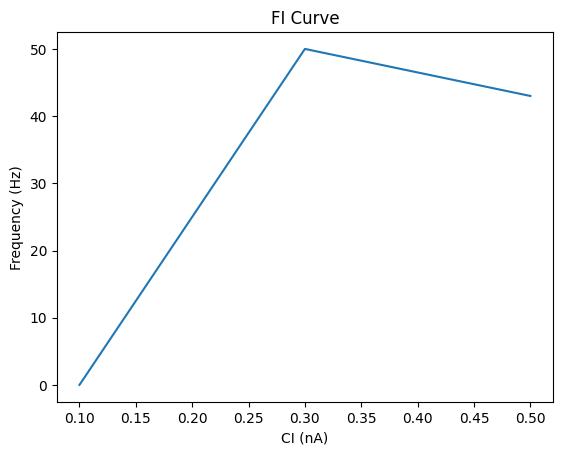

In [25]:
simulated_data = np.load("output/spiker_seg-10_after/combined_out.npy")

f = []
for trace_id in range(len(simulated_data)):
    f.append(len(dp.find_events(simulated_data[trace_id, ::10, 0].flatten())))

plt.plot([0.1, 0.3, 0.5], f)
plt.xlabel("CI (nA)")
plt.ylabel("Frequency (Hz)")
plt.title("FI Curve")